In [1]:
!wget "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif"
!wget "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif"

--2023-05-04 17:26:33--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) [application/octet-stream]
Saving to: ‘training.tif’

training.tif        100%[===================>] 123.90M  1.01MB/s    in 3m 24s  

2023-05-04 17:29:57 (623 KB/s) - ‘training.tif’ saved [129919357/129919357]

--2023-05-04 17:29:57--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) 

In [2]:
!pip install --upgrade pip

!pip install patchify
!pip install tensorflow-gpu
# !pip install tensorflow
!pip install keras
!pip install segmentation-models
!pip install stardist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for detai

In [3]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
# matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

import os
import cv2


from patchify import patchify
from PIL import Image
# import segmentation_models as sm


from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
!pip install segmentation-models

!pip install multipagetiff
import multipagetiff as mtif 

# load the Data from google drive
img = mtif.read_stack("/content/training.tif", units='um')
msk = mtif.read_stack("/content/training_groundtruth.tif", units='um')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:

scaler = MinMaxScaler()
patch_size = 256 # the size of patches

image_dataset = []  # preparing dataset(images) 
for k in range(img.shape[0]):
  patches_img = patchify(img[k,:,:], (patch_size, patch_size), step=patch_size)  # extracing patches with no overlap
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]

      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

      image_dataset.append(single_patch_img)

mask_dataset = []   # preparing dataset(masks) 
for k in range(msk.shape[0]):
  patches_mask = patchify(msk[k,:,:], (patch_size, patch_size), step=patch_size)  # extracing patches with no overlap
  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
        
        single_patch_mask = patches_mask[i,j,:,:]
        mask_dataset.append(single_patch_mask)


'''#Normalize images  ''' # these data are already normalized but this step is crucial 
image_dataset = np.expand_dims(np.array(image_dataset),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) 


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)


In [6]:
"""
#Read input image and corresponding mask names
X = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_images/*.tif'))
Y = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_masks/*.tif'))

     

#Read images and masks using their names.
#We are using tifffile library to read images as we have tif images. 
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.
     

"""

"\n#Read input image and corresponding mask names\nX = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_images/*.tif'))\nY = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_masks/*.tif'))\n\n     \n\n#Read images and masks using their names.\n#We are using tifffile library to read images as we have tif images. \nX = list(map(imread,X))\nY = list(map(imread,Y))\nn_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.\n     \n\n"

In [7]:
X = np.array(image_dataset[0:160,:,:,:])
Y = np.array(mask_dataset[0:160,:,:,:])
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [8]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.


In [9]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = np.squeeze(np.array([normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]))
Y = np.squeeze(np.array([fill_label_holes(y) for y in tqdm(Y)]))

100%|██████████| 160/160 [00:00<00:00, 915.42it/s]


In [10]:
#Split to train and val
#You can use any method to split. I am following the method used in StarDist documentation example
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 160
- training:       136
- validation:      24


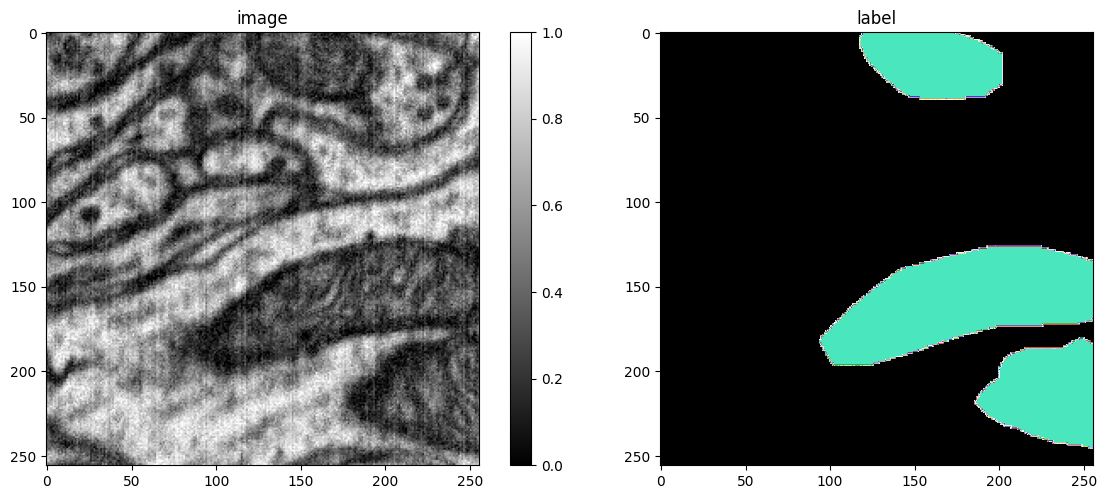

In [11]:

#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()
    
    
i = min(5, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)


In [12]:

#Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [13]:

#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [14]:

if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [15]:
#Save model to the specified directory
model = StarDist2D(conf, name='stardist_tutorial', basedir='/content/drive/MyDrive/Colab Notebooks/models')
     

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [16]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(np.squeeze(Y)), np.median)
fov = np.array(model._axes_tile_overlap('YX')) + 36
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")
    
     

1/1 [==============================] - 0s 19ms/step
median object size:      [126.5 114. ]
network field of view :  [129 130]


In [17]:
#Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

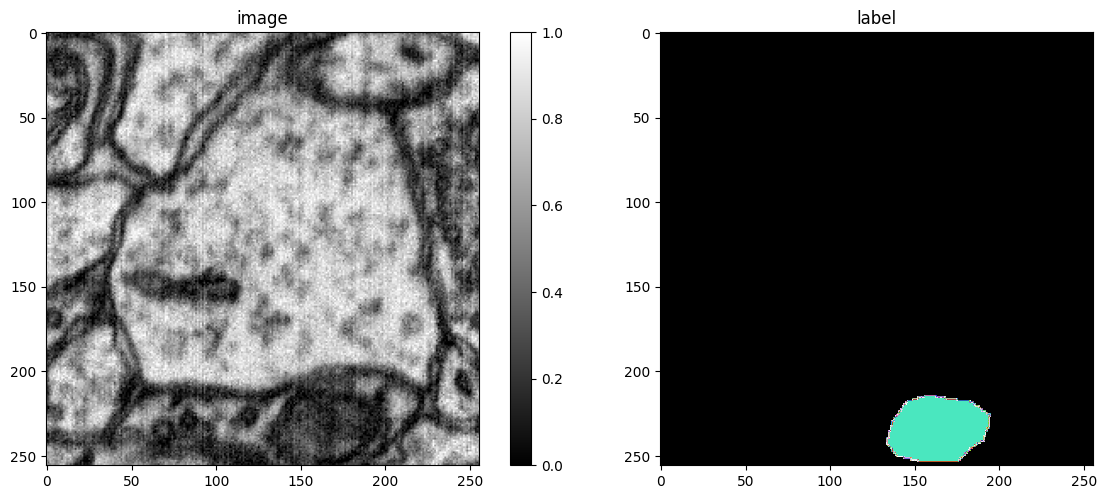

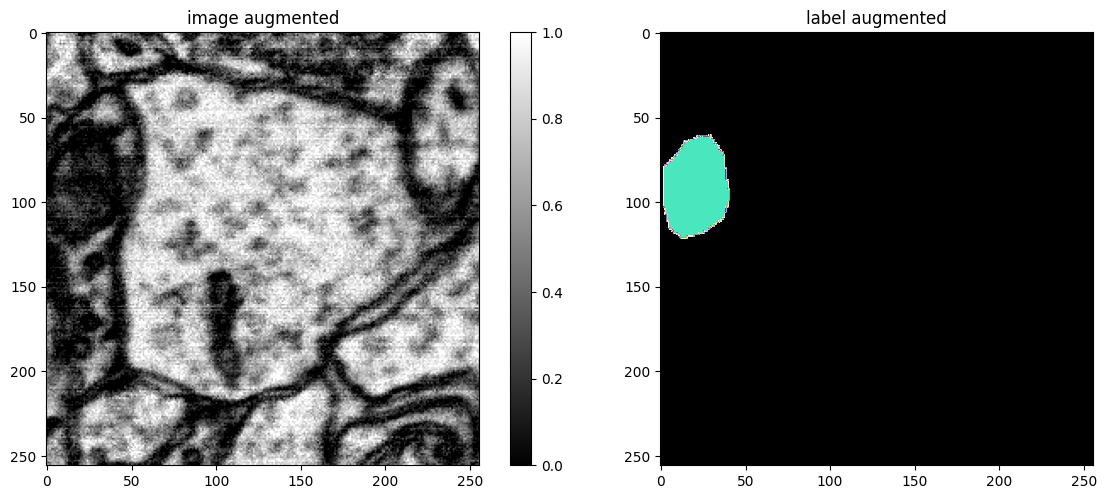

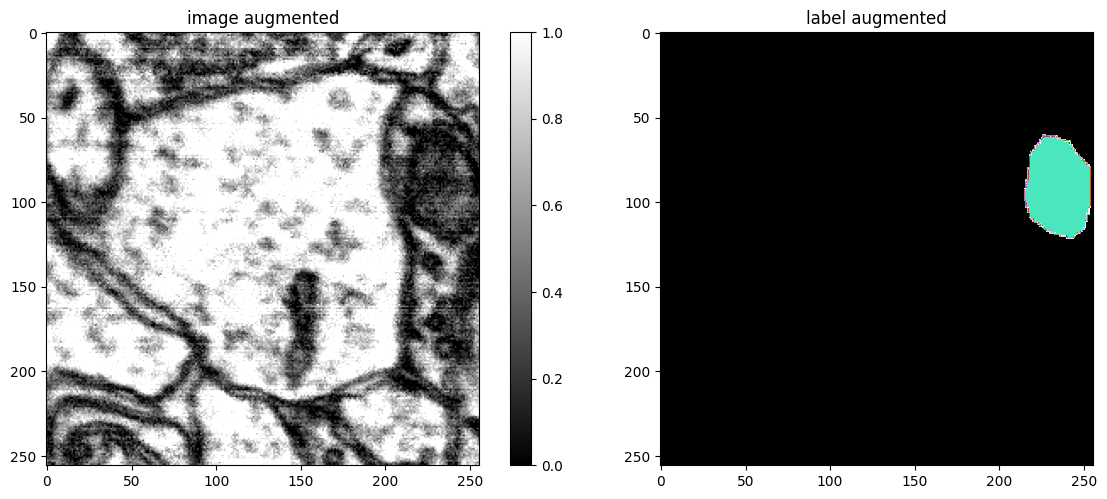

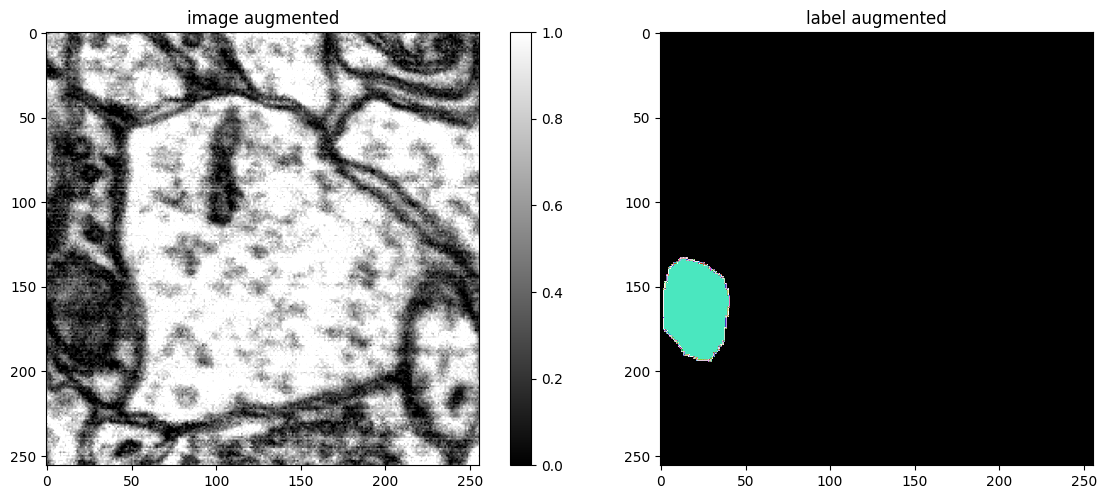

In [18]:

# plot some augmented examples
img, lbl = X[9],Y[9]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")
    
     

In [19]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=150, steps_per_epoch=100)


Epoch 1/150


Cause: Unable to locate the source code of <function _gcd_import at 0x7f876dfc3400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f876dfc3400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 21s 81ms/step - loss: 4.4862 - prob_loss: 0.3248 - dist_loss: 20.8071 - prob_kld: 0.2364 - dist_relevant_mae: 20.8056 - dist_relevant_mse: 742.5678 - dist_dist_iou_metric: 0.1764 - val_loss: 2.9717 - val_prob_loss: 0.1331 - val_dist_loss: 14.1927 - val_prob_kld: 0.1001 - val_dist_relevant_mae: 14.1910 - val_dist_relevant_mse: 365.3288 - val_dist_dist_iou_metric: 0.2614 - lr: 3.0000e-04
Epoch 2/150
100/100 [===========================

In [20]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

1/1 [==============================] - 0s 21ms/step


NMS threshold = 0.5:  80%|████████  | 16/20 [00:02<00:00,  7.69it/s, 0.465 -> 0.258]


Using optimized values: prob_thresh=0.463583, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.46358292092036213, 'nms': 0.3}

In [21]:
"""#Load saved model
my_model = StarDist2D(None, name='stardist', basedir='/content/drive/MyDrive/Colab Notebooks/models')
     
model=my_model"""

"#Load saved model\nmy_model = StarDist2D(None, name='stardist', basedir='/content/drive/MyDrive/Colab Notebooks/models')\n     \nmodel=my_model"

In [22]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|          | 0/24 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 2/24 [00:00<00:01, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 4/24 [00:00<00:01, 13.99it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 6/24 [00:00<00:01, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 8/24 [00:00<00:01, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 10/24 [00:00<00:01, 13.19it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 12/24 [00:00<00:00, 13.21it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 14/24 [00:01<00:00, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 16/24 [00:01<00:00, 13.03it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 18/24 [00:01<00:00, 12.98it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 20/24 [00:01<00:00, 13.40it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 22/24 [00:01<00:00, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 24/24 [00:01<00:00, 13.43it/s]


100%|██████████| 9/9 [00:00<00:00, 16.64it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=25, tp=12, fn=12, precision=0.32432432432432434, recall=0.5, accuracy=0.24489795918367346, f1=0.39344262295081966, n_true=24, n_pred=37, mean_true_score=0.37141988674799603, mean_matched_score=0.7428397734959921, panoptic_quality=0.2922648289164559, by_image=False)

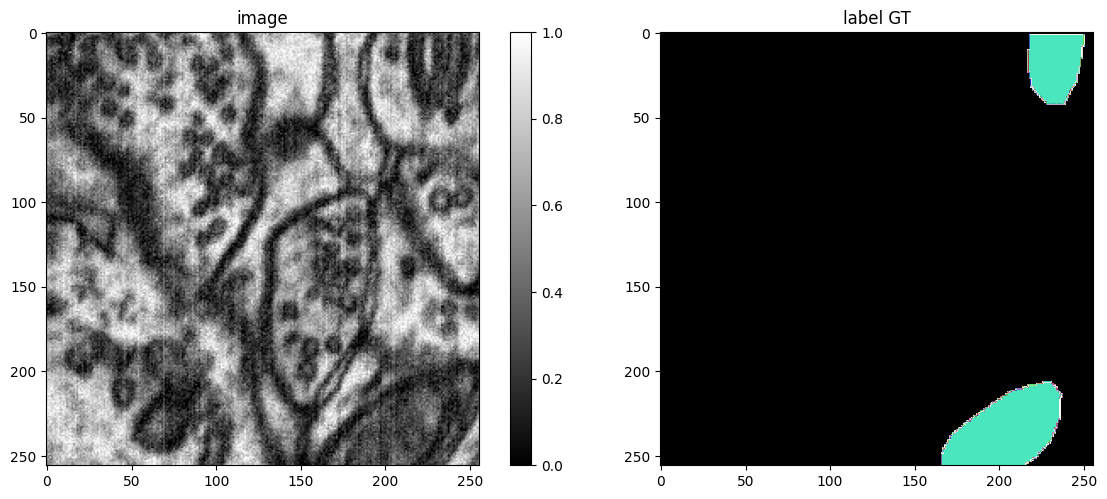

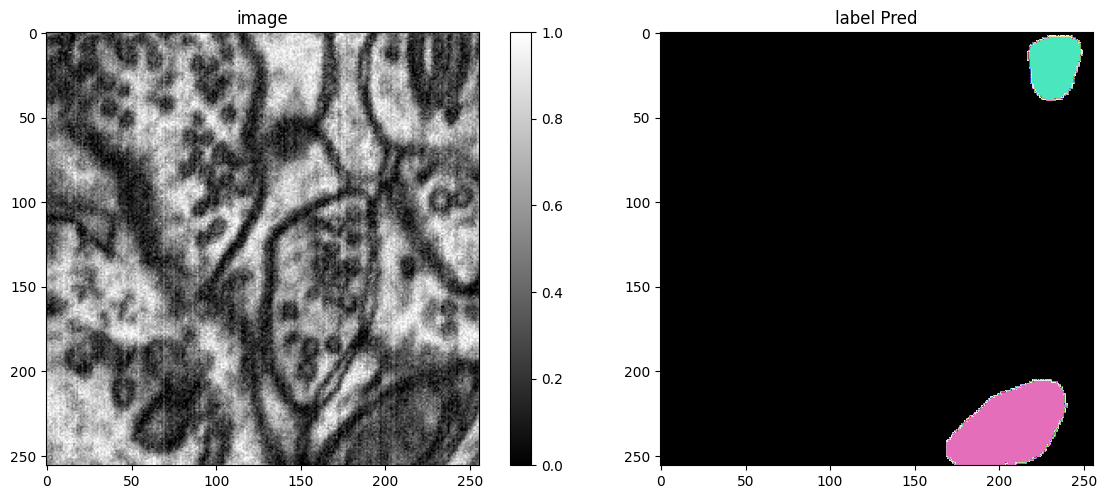

In [23]:

#PLot original labels and predcitions
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]


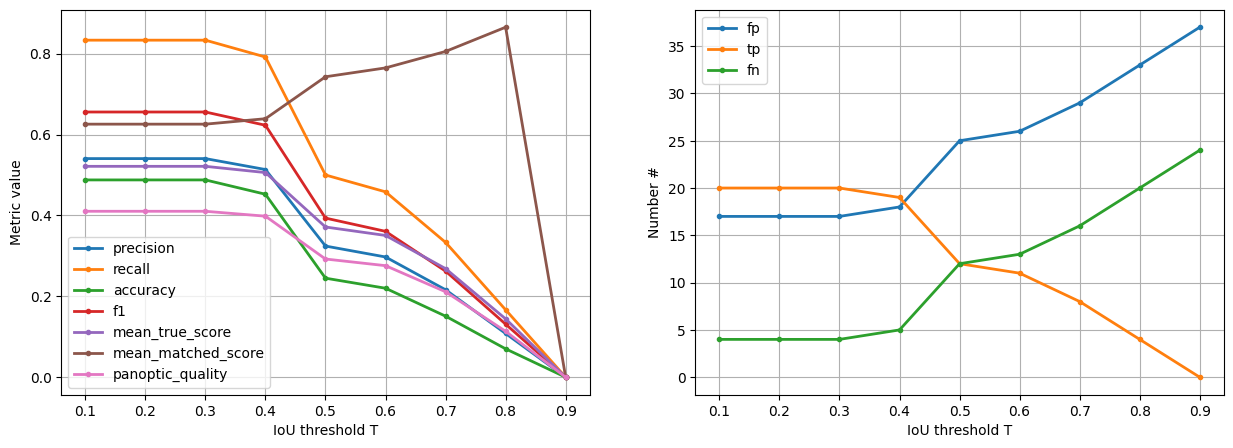

In [24]:

#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold T')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold T')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();


In [25]:
#predicting using the trained model 

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
# matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tifffile import imread
from tqdm import tqdm
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from stardist.plot import render_label

In [26]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [46]:
#Read images to be segmented.
# X = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_images/*.tif'))
# X = list(map(imread,X))
X = (np.squeeze(image_dataset[170:170+160,:,:,:]))

#Verify the size of our images
X.shape

(160, 256, 256)

In [47]:
X2[0].shape

(256, 256)

In [48]:

#Define the number of channels and normalize images with independendt channels or jointly
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]   
    


100%|██████████| 160/160 [00:00<00:00, 487.14it/s]


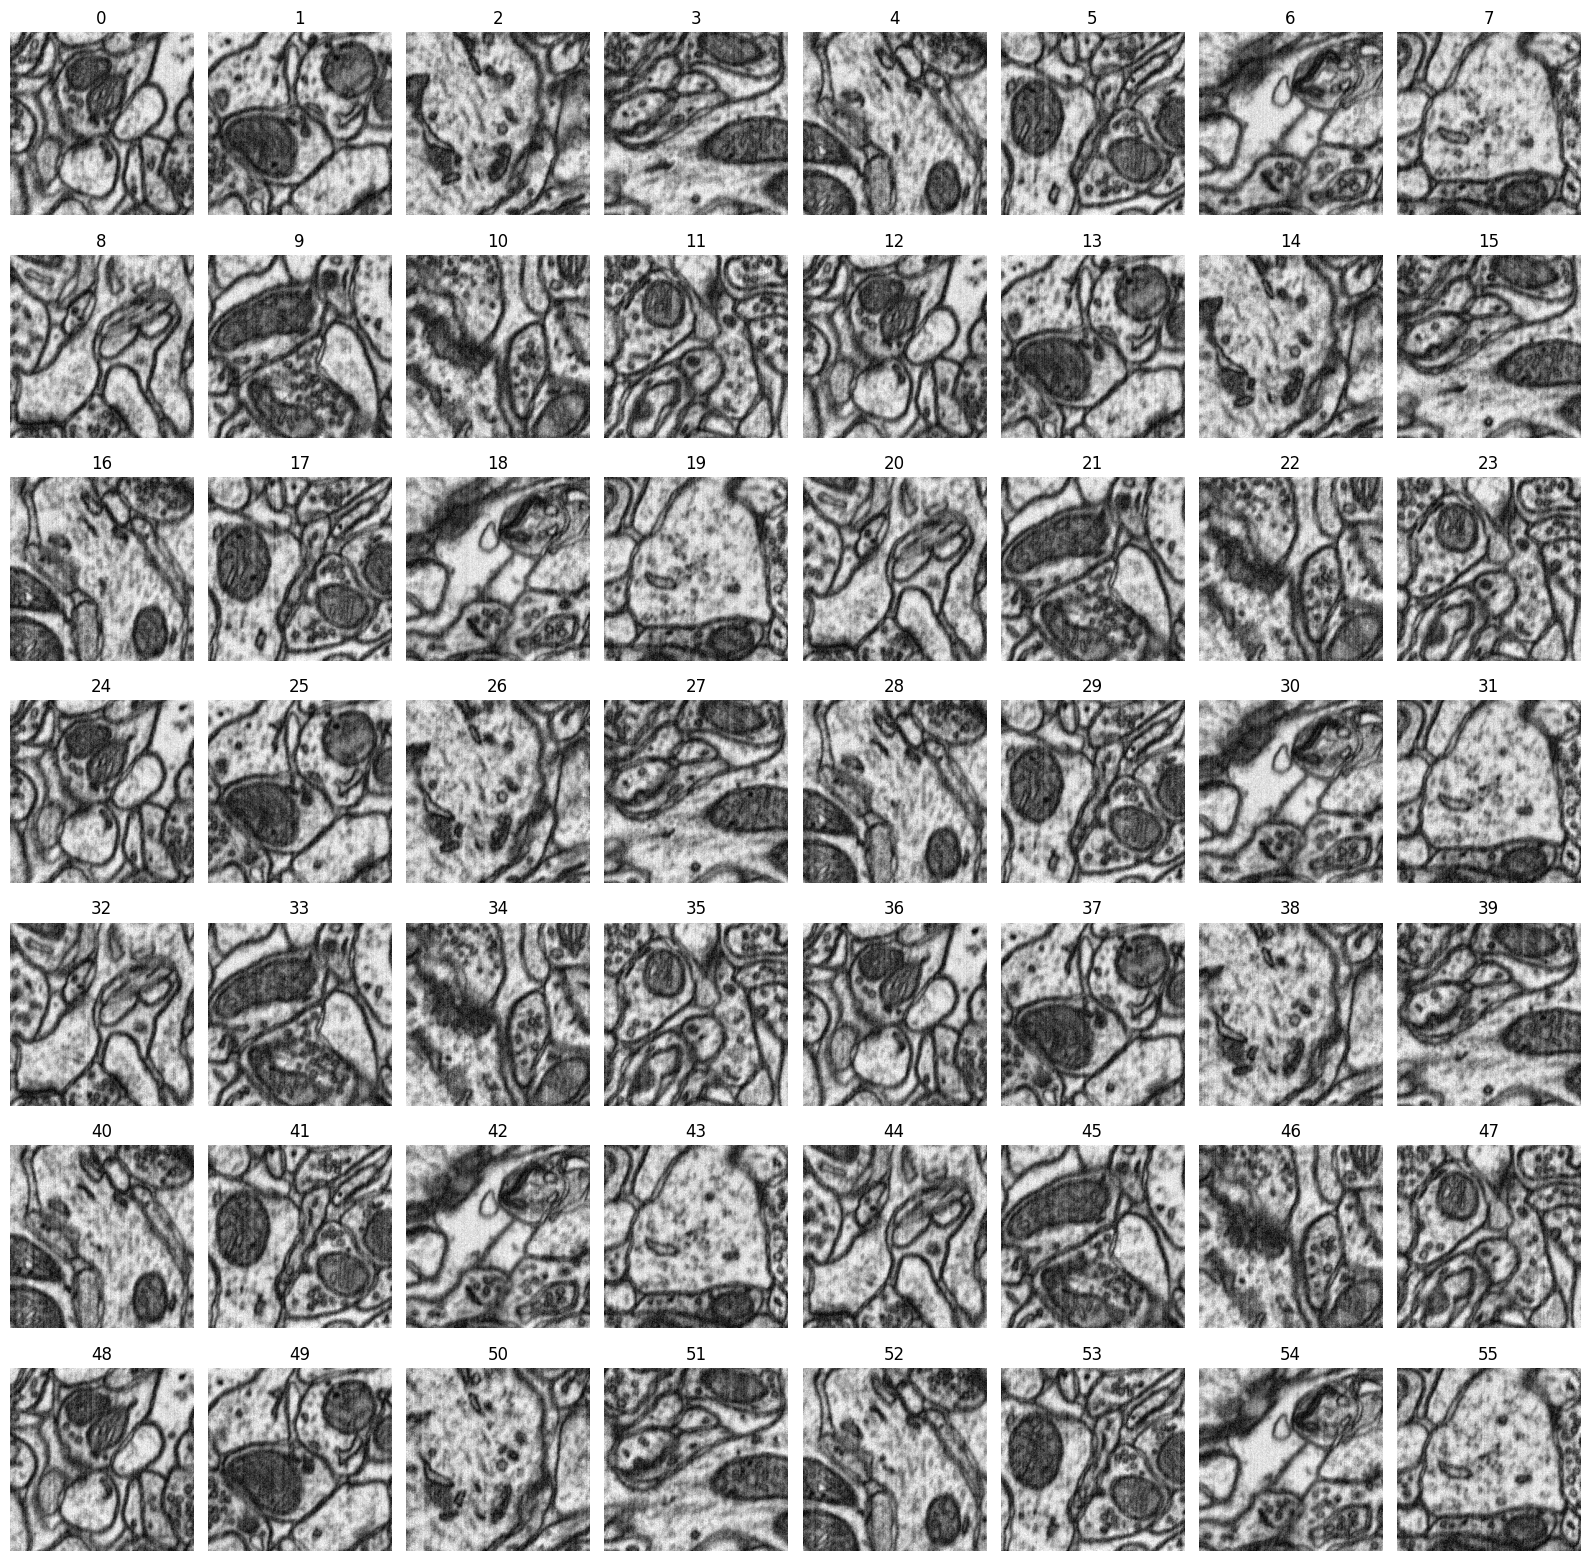

In [49]:

fig, ax = plt.subplots(7,8, figsize=(16,16))
for i,(a,x) in enumerate(zip(ax.flat, X)):
  a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
  a.set_title(i)
  [a.axis('off') for a in ax.flat]
  plt.tight_layout()

In [50]:
model = StarDist2D(None, name='stardist_tutorial', basedir='/content/drive/MyDrive/Colab Notebooks/models')


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.463583, nms_thresh=0.3.


In [51]:
from random import randint


1/1 [==============================] - 0s 23ms/step


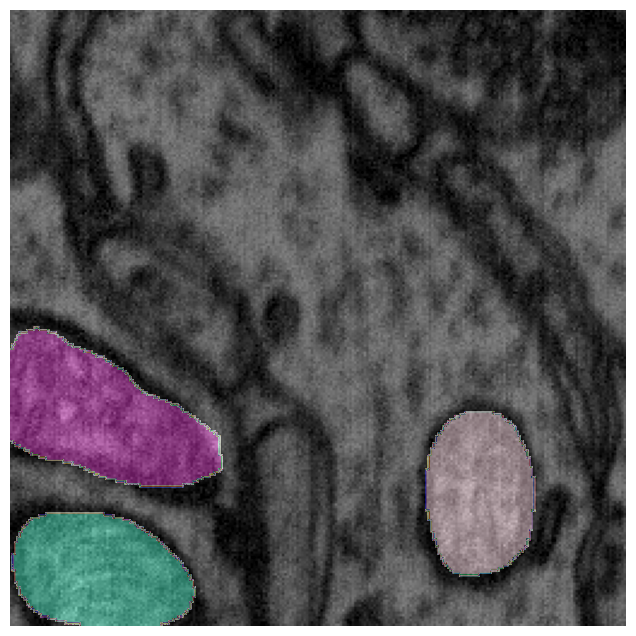

In [67]:
img_num = randint(0, len(X)-1)
img = X[img_num]
#img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)


plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');


1/1 [==============================] - 0s 45ms/step


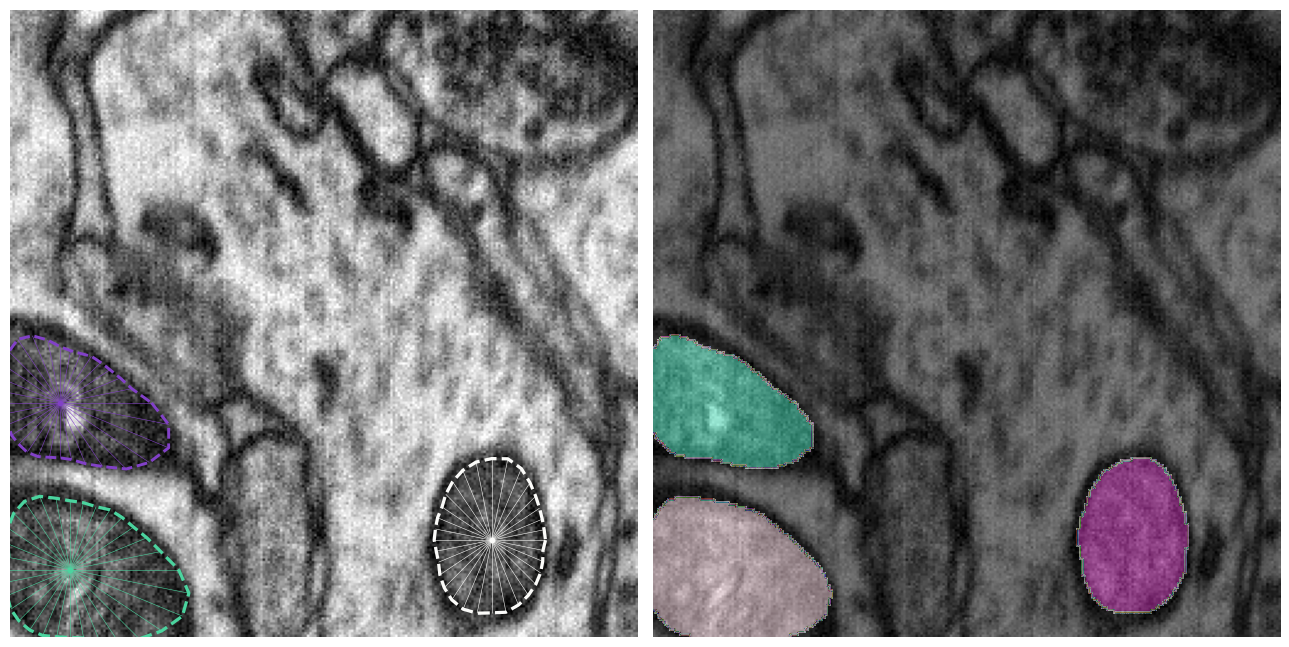

In [68]:
#Plot 

def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    
example(model, 16)

In [73]:
##Segmenting large images
my_img = mtif.read_stack("/content/training.tif", units='um')
my_img = my_img[150:150+12,:,:]


In [92]:
my_img_norm = normalize(my_img[11], 1,99.8, axis=axis_norm)


In [93]:
# model.predict_instances(..., n_tiles = (2,4,4)) crop the input images in the respective number of tiles (also takes care of voerlap)
segmented_img, details_img = model.predict_instances(my_img_norm, verbose=True)
     

1/1 [==============================] - 0s 23ms/step
predicting instances with nms_thresh = 0.3
non-maximum suppression...
keeping 12/2364 polyhedra
NMS took 0.0303 s


Text(0.5, 1.0, 'prediction')

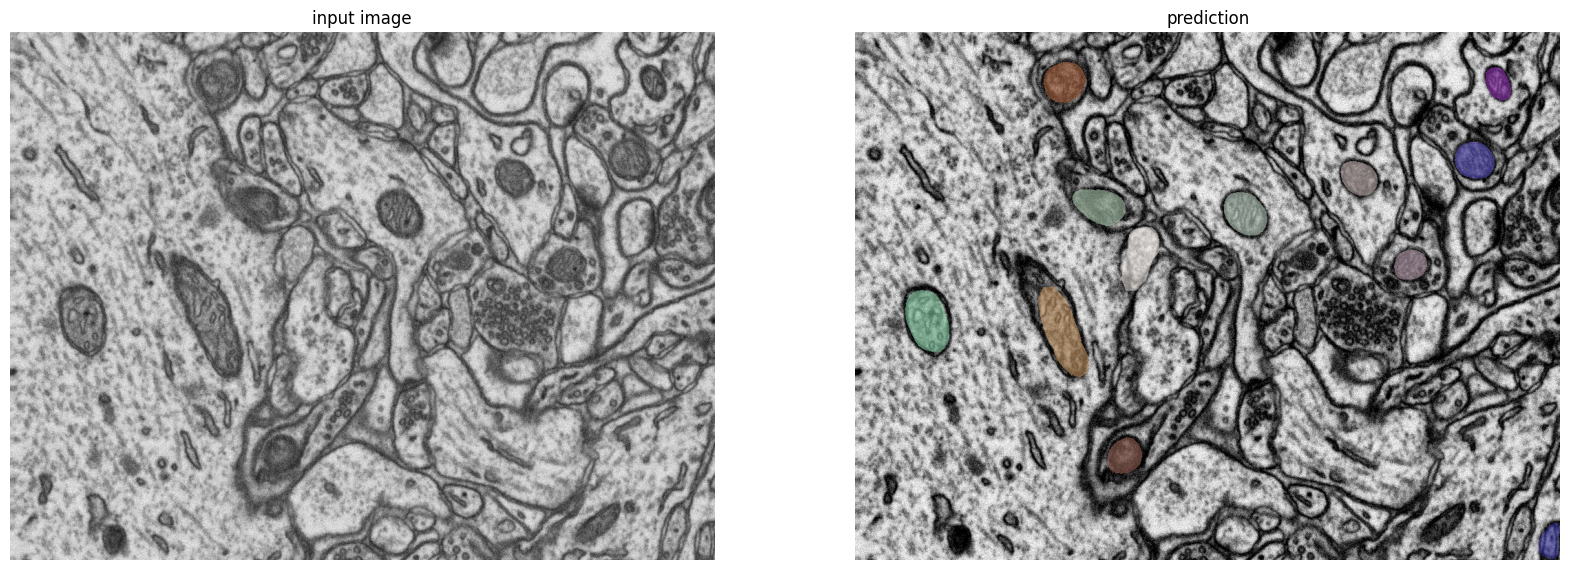

In [94]:

plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,2,1)
plt.imshow(my_img_norm, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(segmented_img, img=my_img_norm))
plt.axis("off")
plt.title("prediction")